# 08 - Carbon-Based Materials

**Overview** 

This notebook guides you through the simulation of ideal periodic crystalline structures of carbon-based materials. The goal of the calculations is to describe the electronic states (bands) of different phases and to understand how these states define their physical properties related to electronic conduction (insulators vs conductor vs semi metal) and mechanical properties (equilibrium lattice constant/volume and bulk modulus).

**Modules Setup**

NOTE: the following cell will return an error when run through Collab. This is because qepy requires an older version of numpy with respect to the one installed by default on Collab. After the error, Collab will ask you to restart the session. Click on "Restart session" and run the cell again. The second time the cell should run without returing an error.

In [2]:
# @title Install qepy package  { display-mode: "form" }
!pip install qepy 

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# @title Modules Setup { display-mode: "form" }
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
!pip install -q ase > /dev/null
from ase.build import bulk, graphene, stack
from ase.io import write
from ase import Atoms
from ase.visualize import view
from qepy.calculator import QEpyCalculator

**Problem** 

We want to understand how the crystal structure affects the physical properties of different phases of carbon-based materials. Can first principles calculations describe the electronic conduction and mechanical properties of different phases of carbon? What density functional is the best at reproducing experimental results?

**Model**
We will use different flavors of density functional theory (DFT) using a plane-wave (PW) basis set and pseudopotentials (PP) to describe core electrons. We will explore the main numerical parameters of PW-PP-DFT to make sure they do not significantly affect the final results. 



**Questions**

Before you run any simulation, answer the following question(s):

1. For which phase of carbon do you expect to find a finite band gap (a energy gap between the highest occupied electronic states and the lowest unoccupied states)? 
2. Which phase of carbon do you expect to have the highest stiffness? 

Run the simulation, change the parameters, and run the simulation again as many times as needed to answer the following question(s):

3. Pick one phase of carbon and explore the effect of the basis set size (ecutwfc) on the computed total energy of the system. 
4. Since in most situations we will be using a special type of PP, called ultrasoft (US or )

In [1]:
# @title Simulation Parameters  { display-mode: "form" }
ecutwfc = 20  # @param {type:"number"}
ecutrho = 200  # @param {type:"number"}
conv_thr = 1e-6  # @param {type:"number"}
functional = "PBE"  # @param ["LDA", "PBE", "PBESOL", "BLYP"]
phase = "graphite"  # @param ["diamond", "graphite", "graphene"]
occupations = "fixed"  # @param ["smearing", "fixed"]
kpoints = "1 1 1 0 0 0"  # @param {type:"string"}

if functional == "LDA":
    pseudopotential = "C.pz-n-rrkjus_psl.0.1.UPF"
elif functional == "PBE":
    pseudopotential = "C.pbe-n-rrkjus_psl.1.0.0.UPF"
elif functional == "PBESOL":
    pseudopotential = "C.pbesol-n-rrkjus_psl.1.0.0.UPF"

qe_options = {
    '&control': {
        'calculation': "'scf'",
        'prefix': "'"+phase+"'",
        'pseudo_dir': "'/tmp/'",
    },
    '&system': {
        'ibrav': 0,
        'ecutwfc': ecutwfc,
        'ecutrho': ecutrho,
        'occupations': "'"+occupations+"'",
        'smearing': "'gaussian'",
        'degauss': 0.01,
    },
    '&electrons': {
        'conv_thr': conv_thr,
    },
    'atomic_species': ['C 28.0855 '+pseudopotential],
    'k_points automatic': [kpoints],
}

# Download pseudopotential
# !wget -O /tmp/$pseudopotential http://pseudopotentials.quantum-espresso.org/upf_files/$pseudopotential 
# In case wget is not available
!curl -l http://pseudopotentials.quantum-espresso.org/upf_files/$pseudopotential -o ./$pseudopotential

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  747k  100  747k    0     0   373k      0  0:00:02  0:00:02 --:--:--  374k14667      0  0:00:52 --:--:--  0:00:52 14727


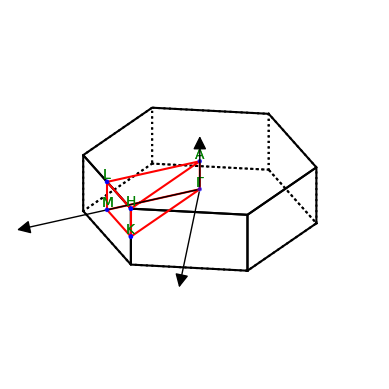

HEX(a=2.46, c=6.7)
  Variant name: HEX
  Special point names: GMKALH
  Default path: GMKGALHA,LM,KH

  Special point coordinates:
    G   0.0000  0.0000  0.0000
    M   0.5000  0.0000  0.0000
    K   0.3333  0.3333  0.0000
    A   0.0000  0.0000  0.5000
    L   0.5000  0.0000  0.5000
    H   0.3333  0.3333  0.5000



In [4]:
# @title Generate and Visualize the System  { display-mode: "form" }
show = 'reciprocal'  # @param ["direct", "reciprocal"]

if phase == "graphite":
    a = 2.46   # in-plane lattice parameter (Å)
    c = 6.70   # c-axis (Å), ~ 2 × 3.35 Å interlayer spacing

    # Hexagonal cell vectors
    cell = [
        (a, 0.0, 0.0),
        (a/2, a*np.sqrt(3)/2, 0.0),
        (0.0, 0.0, c)
    ]

    # AB stacking (P6_3/mmc): 4 atoms per conventional hex cell
    # fractional coords: layer 1 (z=0):        (0,0,0), (1/3,1/3,0)
    #                     layer 2 (z=1/2):     (0,0,1/2), (2/3,2/3,1/2)
    frac = [
        (0.0,   0.0,   0.0),
        (1/3,   1/3,   0.0),
        (0.0,   0.0,   0.5),
        (2/3,   2/3,   0.5),
    ]
    system = Atoms('C4', cell=cell, scaled_positions=frac, pbc=True)
elif phase == "graphene":
    # Conventional hexagonal cell
    a = 2.46
    system = graphene(formula='C2', a=a, vacuum=10.0)  # ~10 Å vacuum
elif phase == "diamond":
    # Conventional diamond cubic cell
    a = 3.567
    system = bulk('C', 'diamond', a=a)
calc = QEpyCalculator(qe_options=qe_options, logfile='C_diamond.out')
system.calc=calc
    
if show == 'direct':
    view(system, viewer='x3d')
    write('-', system, format='extxyz')
elif show == 'reciprocal':
    lat = system.cell.get_bravais_lattice()
    lat.plot_bz(show=True)
    print(lat.description())

In [ ]:
# @title Run the calculation { display-mode: "form" }
energy = system.get_potential_energy()
efermi = calc.get_fermi_level()

# run a non-scf calculation to get band energies, increase k-points density
qe_options['k_points automatic']= ['8 8 8 0 0 0']
energies, dos = system.calc.get_dos(qe_options, width=0.6)

# run band structure calculation along high-symmetry path
if phase == "graphene":
    path = system.cell.bandpath('GKMG',npoints=61)
    qe_options['&system']['nbnd']=6
elif phase == "graphite":
    path = system.cell.bandpath('GMKGALHA',npoints=61)
    qe_options['&system']['nbnd']=12
elif phase == "diamond":
    path = system.cell.bandpath('GXWKGLUWLK',npoints=61)
    qe_options['&system']['nbnd']=6

band = system.calc.get_band_structure(qe_options, kpts=path, reference=efermi)

: 

In [38]:
# @title Plot Band Structure and DOS { display-mode: "form" }
# ----- Helper: extract plot-ready data from band object -----
def _extract_band_data(band):
    """
    Returns:
      kdist: 1D array of cumulative k-point distances
      bands: 2D array shape (n_bands, n_kpts) with energies in eV (referenced to EF)
      xticks: list of x positions for high-symmetry points
      xlabels: list of labels (strings) for those ticks
    """
    # Common ASE/QEpy patterns
    # Try a dedicated getter if present
    for getter in ("get_plot_data", "plot_data", "get_data"):
        if hasattr(band, getter):
            out = getattr(band, getter)()
            # expected variants:
            # (kdist, bands, xticks, xlabels) or a dict with similar keys
            if isinstance(out, dict):
                kdist   = out.get("x") or out.get("kdist") or out.get("kpoints") or out.get("kpath")
                bands   = out.get("y") or out.get("energies") or out.get("bands")
                xticks  = out.get("xticks") or out.get("tick_positions") or []
                xlabels = out.get("xlabels") or out.get("tick_labels") or []
            else:
                # assume a tuple
                if len(out) >= 2:
                    kdist, bands = out[0], out[1]
                else:
                    raise ValueError("Unexpected band plot data format.")
                xticks  = out[2] if len(out) > 2 else []
                xlabels = out[3] if len(out) > 3 else []
            return np.asarray(kdist), np.asarray(bands), xticks, xlabels

    # Try attribute-based access
    kdist_candidates = ["kdist", "k_distance", "x", "kpoints", "k_path"]
    bands_candidates = ["energies", "eigs", "bands", "y"]
    ticks_candidates = [("xticks", "xlabels"), ("ticks", "labels"), ("tick_positions", "tick_labels")]

    kdist = None
    for name in kdist_candidates:
        if hasattr(band, name):
            kdist = getattr(band, name)
            break

    bands = None
    for name in bands_candidates:
        if hasattr(band, name):
            bands = getattr(band, name)
            break

    xticks, xlabels = [], []
    for tname, lname in ticks_candidates:
        if hasattr(band, tname) and hasattr(band, lname):
            xticks  = getattr(band, tname)
            xlabels = getattr(band, lname)
            break

    if kdist is None or bands is None:
        raise RuntimeError("Could not extract band data – consider using band.plot_data()-like APIs.")
    return np.asarray(kdist), np.asarray(bands), xticks, xlabels


# ----- Prepare data -----
# 'energies' and 'dos' from your earlier call (already broadened)
# Make sure the energies are referenced to E_F = 0
E = np.asarray(energies) - efermi
D = np.asarray(dos)

# Optional: choose a plotting energy window
emin, emax = -6.0, 6.0

# Get band-plot arrays from band object
kdist, bands_2d, xticks, xlabels = _extract_band_data(band)
# Ensure bands are (n_bands, n_kpts)
if bands_2d.shape[0] < bands_2d.shape[1]:
    # assume shape (n_kpts, n_bands) -> transpose
    bands_2d = bands_2d.T

# ----- Figure layout -----
fig = plt.figure(figsize=(8, 5), dpi=120)
gs = GridSpec(nrows=1, ncols=2, width_ratios=[3.0, 1.2], wspace=0.15, figure=fig)
ax_b = fig.add_subplot(gs[0, 0])  # bands
ax_d = fig.add_subplot(gs[0, 1], sharey=ax_b)  # DOS shares y axis with bands

# ----- Plot bands (left) -----
for band_vals in bands_2d:
    ax_b.plot(kdist, band_vals, lw=1.0)

# High-symmetry ticks/labels
if isinstance(xticks, (list, tuple, np.ndarray)) and len(xticks) > 0:
    ax_b.set_xticks(xticks)
    if xlabels and (len(xlabels) == len(xticks)):
        # Pretty LaTeX-ish Γ if present
        labmap = {"G": r"$\Gamma$", "Γ": r"$\Gamma$"}
        labels = [labmap.get(lbl, lbl) for lbl in xlabels]
        ax_b.set_xticklabels(labels)
# Vertical lines at HS points
for x in (xticks or []):
    ax_b.axvline(x, color="k", lw=0.5, alpha=0.3)

# E_F reference line
ax_b.axhline(0.0, color="k", lw=0.8, ls="--", alpha=0.6)

ax_b.set_xlim(kdist.min(), kdist.max())
ax_b.set_ylim(emin, emax)
ax_b.set_ylabel("Energy (eV)")
ax_b.set_xlabel("k-path")
ax_b.set_title("Band structure")

# ----- Plot DOS (right) -----
# Limit DOS energy range to match band plot, and make DOS positive
mask = (E >= emin) & (E <= emax)
Eplot = E[mask]
Dplot = np.abs(D[mask])

# Scale DOS to a nice width relative to bands pane
# (you can adjust the multiplier if you want a wider/narrower DOS)
if Dplot.max() > 0:
    Dscale = Dplot / Dplot.max()
else:
    Dscale = Dplot

ax_d.plot(Dscale, Eplot, lw=1.2)
ax_d.fill_betweenx(Eplot, 0, Dscale, alpha=0.15)

# Vertical axis shared -> only x label here
ax_d.set_xlabel("DOS (arb.)")
ax_d.set_ylim(emin, emax)
ax_d.set_yticklabels([])  # keep y only on left
ax_d.grid(False)
ax_d.set_title("DOS")

# Fermi level line (y=0), drawn across the DOS axis as well
ax_d.axhline(0.0, color="k", lw=0.8, ls="--", alpha=0.6)

plt.show()

NameError: name 'energies' is not defined

**Homework Assignment**

Pick one (or more) of the following projects:
1. Select a periodic molecular or crystalline system and perform DFT simulations with at least two different density functionals (e.g. LDA and PBE)
2. Optimize the lattice parameter of the system (equation of state)
3. Verify the effect of the size of the basis set on the optimal lattice parameter
